In [1]:
%matplotlib inline 
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import *
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(40)
tf.random.set_seed(40)

In [2]:
#inital parameters
height, width = 224,224
batch_size = 64

In [3]:
path = 'brain_tumor_dataset'

In [4]:
path

'brain_tumor_dataset'

In [11]:
def ima_generator(height,width):
    datagen = ImageDataGenerator(
                rescale=1./255.,
                validation_split=0.2,
                )
    
    train_data = datagen.flow_from_directory(
                path,
                batch_size=batch_size,
                shuffle = True,
                class_mode='binary',
                target_size=(height,width),
                classes={'no':0., 'yes':1.}
                )
    val_data =datagen.flow_from_directory(
                path,
                batch_size=batch_size,
                shuffle = True,
                class_mode='binary',
                target_size=(height,width),
                classes={'no':0., 'yes':1.}
                )
    return train_data,val_data

train_data, val_data = ima_generator(height,width)

total_image = np.concatenate([train_data.labels,val_data.labels])

print('\n\n', {'No_brain_Tumor':len(np.where(total_image==0)[0]),
                'Yes_brain_Tumor':len(np.where(total_image==1)[0])})

Found 253 images belonging to 2 classes.
Found 253 images belonging to 2 classes.


 {'No_brain_Tumor': 196, 'Yes_brain_Tumor': 310}


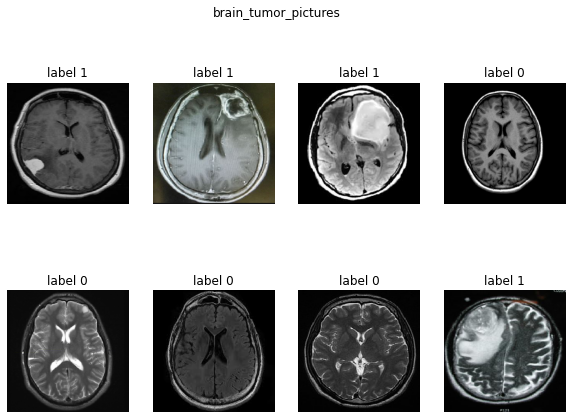

In [15]:
# img demonstration
fig, ax = plt.subplots(2, 4, figsize=(10, 7))
fig.suptitle("brain_tumor_pictures")
for k in range(8):
    images, labels = train_data.next()
    i, j = k//4, k%4
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f'label {int(labels[0])}')
    ax[i, j].axis('off')
plt.show()

In [16]:
from tensorflow.keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.vgg19.VGG19(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

vgg19 = tf.keras.Sequential()
vgg19.add(base_model)
vgg19.add(tf.keras.layers.Flatten())

vgg19.add(tf.keras.layers.Dense(1, activation='sigmoid'))

vgg19.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.01),
              metrics=['acc'])
vgg19.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [17]:
history = vgg19.fit(train_data,validation_data=val_data, epochs=5,shuffle=True,verbose=True)

Epoch 1/5
4/4 [==============================] - 215s 63s/step - loss: 6.7722 - acc: 0.6640 - val_loss: 14.6139 - val_acc: 0.3874
Epoch 2/5
4/4 [==============================] - 226s 67s/step - loss: 9.0489 - acc: 0.4941 - val_loss: 5.5477 - val_acc: 0.6364
Epoch 3/5
4/4 [==============================] - 230s 67s/step - loss: 6.8495 - acc: 0.6245 - val_loss: 2.7906 - val_acc: 0.7668
Epoch 4/5
4/4 [==============================] - 223s 65s/step - loss: 2.8038 - acc: 0.7233 - val_loss: 3.8506 - val_acc: 0.6719
Epoch 5/5
4/4 [==============================] - 221s 65s/step - loss: 2.2199 - acc: 0.7826 - val_loss: 1.8048 - val_acc: 0.8024


In [21]:
train_result = vgg19.evaluate(train_data)
val_result = vgg19.evaluate(val_data)

no_augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
no_augmented_df

4/4 [==============================] - 107s 27s/step - loss: 1.8048 - acc: 0.8024


,Train,Val
Loss,1.804791,1.804791
Acc,0.802372,0.802372


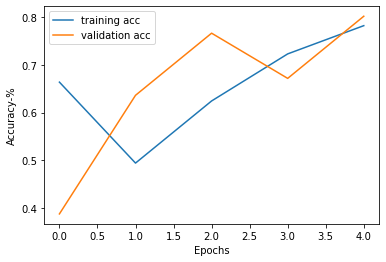

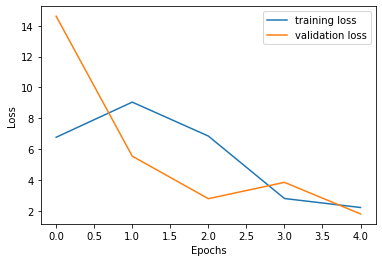

In [22]:
# plot learning curve
def plot_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_curve(history)